In [1]:
from lib.load import extract_data, load_benchmark_corpus


extract_data()
benchmark, corpus = load_benchmark_corpus()

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    # separators=['\n\n', '\n', '!', '?', '.', ':', ';', ',', ' ', ''],
    chunk_size=500,
    chunk_overlap=0,
    add_start_index=True,
)

names, texts = zip(*corpus.items())
metadatas = [
    {"source_file": name}
    for idx, name in enumerate(names)
]

documents = text_splitter.create_documents(corpus.values(), metadatas=metadatas)
documents[:3]

[Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 2}, page_content='At Fiverr we care about your privacy.\nWe do not sell or rent your personal information to third parties for their direct marketing purposes without your explicit consent.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 173}, page_content='We do not disclose it to others except as disclosed in this Policy or required to provide you with the services of the Site and mobile applications, meaning - to allow you to buy, sell, share the information you want to share on the Site; to contribute on the forum; pay for products; post reviews and so on; or where we have a legal obligation to do so.'),
 Document(metadata={'source_file': 'Fiverr.txt', 'start_index': 530}, page_content='We collect information that you provide us or voluntarily share with other users, and also some general technical information that is automatically gathered by our systems, such as IP address, browser information and 

In [3]:
benchmark[0]

{'query': 'Consider "Fiverr"\'s privacy policy; who can see which tasks i hire workers for?',
 'snippets': [{'file_path': 'privacy_qa/Fiverr.txt',
   'span': [3873, 4312],
   'answer': '  In addition, we collect information while you access, browse, view or otherwise use the Site.\nIn other words, when you access the Site we are aware of your usage of the Site, and may gather, collect and record the information relating to such usage, including geo-location information, IP address, device and connection information, browser information and web-log information, and all communications recorded by Users through the Site.\n'}]}

In [4]:
import os

target_spans = []
for test in benchmark:
    snippets = test["snippets"]
    for snippet in snippets:
        start, end = snippet["span"]
        target_spans.append((os.path.basename(snippet['file_path']), start, end))

In [5]:
rag_spans = []
for doc in documents:
    start = doc.metadata['start_index']
    end = start + len(doc.page_content)
    rag_spans.append((doc.metadata['source_file'], start, end))

In [6]:
%matplotlib inline

[Text(0.5, 1.0, 'target lengths')]

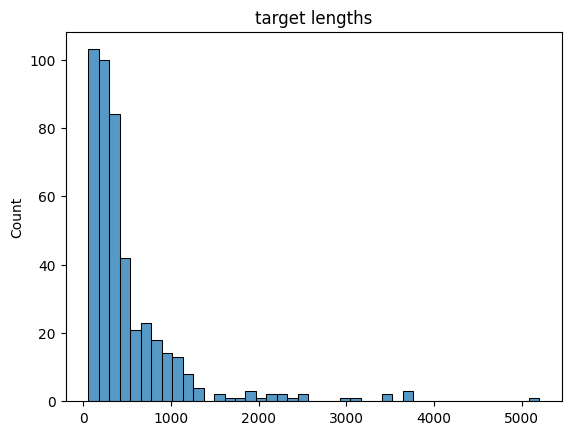

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

target_lengths = [end - start for _, start, end in target_spans]
sns.histplot(target_lengths, label="target lengths").set(title="target lengths")

In [8]:
import statistics

print(statistics.mean(target_lengths), statistics.median(target_lengths))

507.6843267108168 332


[Text(0.5, 1.0, 'chunk lengths')]

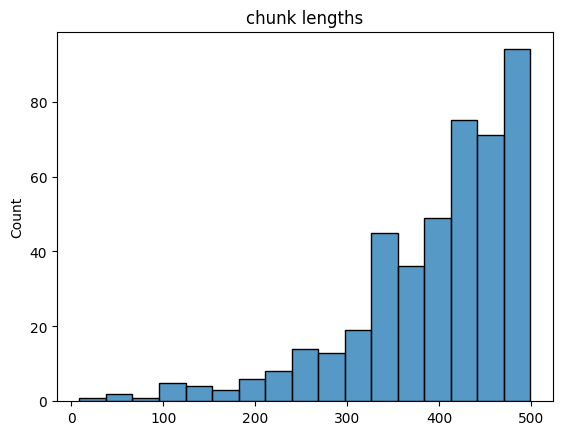

In [9]:
rag_lengths = [end - start for _, start, end in rag_spans]
sns.histplot(rag_lengths).set(title="chunk lengths")

In [10]:
print(statistics.mean(rag_lengths), statistics.median(rag_lengths))

395.3408071748879 419.0


In [11]:
len(target_spans), len(rag_spans)

(453, 446)

In [12]:
from collections import Counter


overlap_count = []
overlap_percentage = []
overlap_inv_percentage = []
for f1, a, b in target_spans:
    i = 0
    max_overlap = 0
    max_inv_overlap = 0
    for f2, c, d in rag_spans:
        if f1 == f2:
            if not (b < c or d < a):
                i += 1
                overlap = min(b, d) - max(a, c)
                max_overlap = max(max_overlap, overlap)
                max_inv_overlap = max(max_inv_overlap, overlap / (d - c))
    overlap_count.append(i)
    overlap_percentage.append(max_overlap / (b - a))
    overlap_inv_percentage.append(max_inv_overlap)

[Text(0.5, 1.0, 'covering set')]

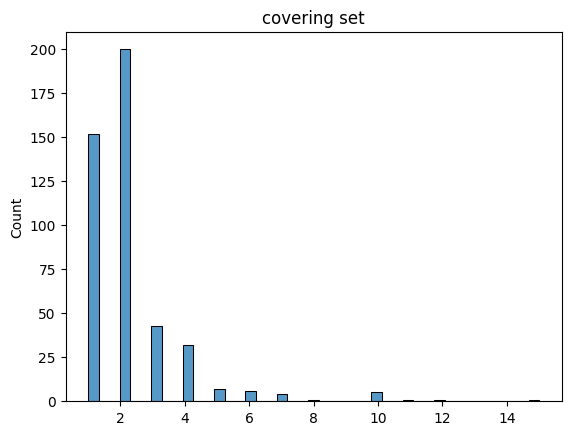

In [13]:
sns.histplot(overlap_count).set(title='covering set')

[Text(0.5, 1.0, 'recall @ 1 upper bounds')]

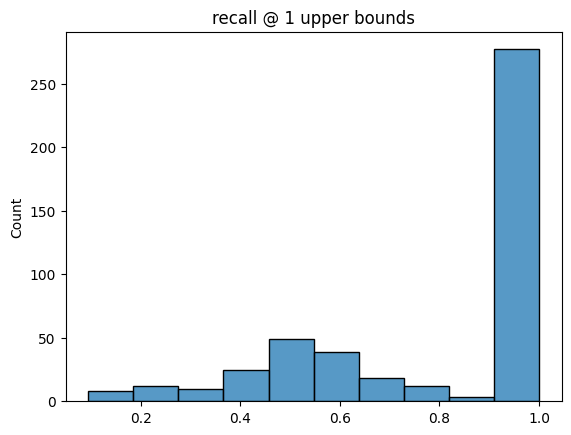

In [14]:
sns.histplot(overlap_percentage).set(title='recall @ 1 upper bounds')

[Text(0.5, 1.0, 'precision upper bounds')]

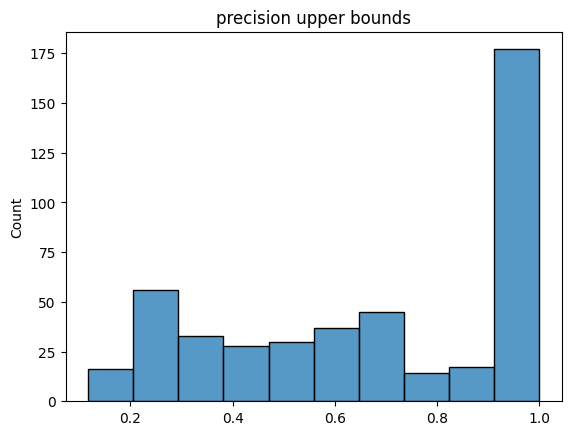

In [15]:
sns.histplot(overlap_inv_percentage).set(title='precision upper bounds')

In [16]:
print(statistics.mean(overlap_count), statistics.median(overlap_count))

2.2163355408388523 2


In [17]:
print(statistics.mean(overlap_percentage), statistics.median(overlap_percentage))

0.8089893016903832 0.9920318725099602


In [18]:
print(statistics.mean(overlap_inv_percentage), statistics.median(overlap_inv_percentage))

0.6862862037479605 0.6842105263157895
